# How does kerchunk handle missing data? 

E.g. a variable is not present in all netcdf files

In [1]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake


In [2]:
import os
import glob

import ujson

import fsspec

import zarr

import xarray as xr

from distributed import Client

from kerchunk import hdf, df, combine

import matplotlib.pyplot as plt

from auto_dask import auto_dask

In [3]:
client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

## Use some files from `/g/data/ik11/outputs/access-om2/1deg_jra55v14_ryf` as a simple test case

In [3]:
dss = [
    (
        "ocean-2d-mld-1-monthly-mean-ym_1900_01.nc", 
        "ocean-2d-surface_pot_temp-1-monthly-mean-ym_1900_01.nc"
    ),
    (
        "ocean-2d-mld-1-monthly-mean-ym_1901_01.nc",
        "ocean-2d-surface_pot_temp-1-monthly-mean-ym_1901_01.nc",
    ),
    (
        "ocean-2d-mld-1-monthly-mean-ym_1902_01.nc",
        "ocean-2d-surface_pot_temp-1-monthly-mean-ym_1902_01.nc"
    )
]

In [8]:
for idx, ds in enumerate(dss):
    data = xr.open_mfdataset(
        [f"./test_data/{d}" for d in ds],
    )
    data = data.drop(
        ["nv", "average_T1", "average_T2", "average_DT"]
    )
    data.to_netcdf(f"./test_data/ds{idx}.nc")

KeyError: 'days since 1900-01-01 00:00:00s'

In [7]:
data

<xarray.Dataset>
Dimensions:           (xt_ocean: 360, yt_ocean: 300, time: 12, nv: 2)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean          (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
  * time              (time) float64 745.5 775.0 804.5 ... 1.049e+03 1.08e+03
Dimensions without coordinates: nv
Data variables:
    mld               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    time_bounds       (time, nv) float64 dask.array<chunksize=(12, 2), meta=np.ndarray>
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-mld-1-monthly-mean-ym_1902_01.nc
    title:      ACCESS-OM2
    grid_type:  mosaic
    grid_tile:  1

## Build kerchunk reference dataset

In [100]:
fs = fsspec.filesystem('file')

files = sorted(fs.glob("./test_data/ds*.nc"))

In [101]:
%%time

@dask.delayed
def gen_json(file):
    
    with fs.open(file) as infile:
        h5chunks = hdf.SingleHdf5ToZarr(infile, file)
        outf = f"{os.path.splitext(file)[0]}.json"
        with open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());
            
_ = dask.compute(*[gen_json(file) for file in files])

CPU times: user 132 ms, sys: 34.7 ms, total: 167 ms
Wall time: 321 ms


In [110]:
%%time

m = fsspec.get_mapper(
    'reference://', 
    fo="./test_data/ds2.json", 
    remote_protocol="file"
)

ds = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": False},
    chunks="auto",
    # decode_times=False
)

CPU times: user 58.2 ms, sys: 0 ns, total: 58.2 ms
Wall time: 47.3 ms


In [111]:
ds

<xarray.Dataset>
Dimensions:           (time: 12, yt_ocean: 300, xt_ocean: 360, nv: 2)
Coordinates:
  * nv                (nv) float64 1.0 2.0
  * time              (time) object 1902-01-16 12:00:00 ... 1902-12-16 12:00:00
  * xt_ocean          (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean          (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
Data variables:
    average_DT        (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1        (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2        (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    mld               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    time_bounds       (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-mld-1-monthly-mean-ym_1902_01.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      ACCESS-OM2

In [84]:
json_list = fs.glob("./test_data/*.json")

mzz = combine.MultiZarrToZarr(
    json_list,
    concat_dims='time',
    # identical_dims=[
    #     "xt_ocean", 
    #     "yt_ocean", 
    #     "nv"
    #  ],
).translate()

In [85]:
mzz

{'version': 1,
 'refs': {'.zgroup': '{"zarr_format":2}',
  'time/.zarray': '{\n    "chunks": [\n        36\n    ],\n    "compressor": null,\n    "dtype": "<f8",\n    "fill_value": 0.0,\n    "filters": null,\n    "order": "C",\n    "shape": [\n        36\n    ],\n    "zarr_format": 2\n}',
  'time/0': 'base64:AAAAAAAAL0AAAAAAAIBGQAAAAAAAoFJAAAAAAABAWkAAAAAAAPBgQAAAAAAAwGRAAAAAAACQaEAAAAAAAHBsQAAAAAAAIHBAAAAAAAAIckAAAAAAAPBzQAAAAAAA2HVAAAAAAADId0AAAAAAAKB5QAAAAAAAeHtAAAAAAABgfUAAAAAAAEh/QAAAAAAAmIBAAAAAAACMgUAAAAAAAISCQAAAAAAAeINAAAAAAABshEAAAAAAAGCFQAAAAAAAVIZAAAAAAABMh0AAAAAAADiIQAAAAAAAJIlAAAAAAAAYikAAAAAAAAyLQAAAAAAAAIxAAAAAAAD0jEAAAAAAAOyNQAAAAAAA4I5AAAAAAADUj0AAAAAAAGSQQAAAAAAA3pBA',
  'time/.zattrs': '{\n    "_ARRAY_DIMENSIONS": [\n        "time"\n    ],\n    "bounds": "time_bounds",\n    "calendar": "NOLEAP",\n    "calendar_type": "NOLEAP",\n    "cartesian_axis": "T",\n    "long_name": "time",\n    "units": "days since 1900-01-01 00:00:00"\n}',
  '.zattrs': '{"filename":"ocean-2d-

## Write to a json file

In [80]:
with open("./intermittent.json", 'wb') as f:
    f.write(ujson.dumps(mzz).encode());
    
for json in json_list:
    os.remove(json)

## Consolidate metadata

In [48]:
m = fsspec.get_mapper(
    'reference://', 
    fo="intermittent.json", 
    remote_protocol="file"
)
zarr.convenience.consolidate_metadata(m)
m.fs.save_json("./intermittent.consolidated.json")

## Write to parquet

In [49]:
os.mkdir("./intermittent.parq")
df.refs_to_dataframe(mzz, "./intermittent.parq", partition=True)

# Compute on the reference datasets and compare to `open_mfdataset`

## 1. Reference JSON dataset

In [63]:
%%time

m = fsspec.get_mapper(
    'reference://', 
    fo="./intermittent.consolidated.json", 
    remote_protocol="file"
)

ds = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": True},
    chunks="auto",
    # decode_times=False
)

CPU times: user 40.7 ms, sys: 12.1 ms, total: 52.8 ms
Wall time: 41.4 ms


In [64]:
ds["mld"].mean(["xt_ocean", "yt_ocean"]).values

array([46.476982, 52.929237, 52.28969 , 59.951706, 59.275932, 56.23698 ,
       50.544292, 59.58676 , 72.010376, 88.87992 , 96.81869 , 90.50623 ,
       59.67854 , 44.011578,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan],
      dtype=float32)

In [65]:
ds

<xarray.Dataset>
Dimensions:           (time: 36, yt_ocean: 300, xt_ocean: 360, nv: 2)
Coordinates:
  * nv                (nv) float64 1.0 2.0
  * time              (time) object 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
  * xt_ocean          (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean          (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
Data variables:
    average_DT        (time) timedelta64[ns] dask.array<chunksize=(36,), meta=np.ndarray>
    average_T1        (time) datetime64[ns] dask.array<chunksize=(36,), meta=np.ndarray>
    average_T2        (time) datetime64[ns] dask.array<chunksize=(36,), meta=np.ndarray>
    mld               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(36, 300, 360), meta=np.ndarray>
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(36, 300, 360), meta=np.ndarray>
    time_bounds       (time, nv) timedelta64[ns] dask.array<chunksize=(36, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-mld-1-monthly-mean-ym_1900_01.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      ACCESS-OM2

In [58]:
ds = xr.open_mfdataset("./test_data/ds*.nc")

In [62]:
ds

<xarray.Dataset>
Dimensions:           (xt_ocean: 360, yt_ocean: 300, time: 36, nv: 2)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean          (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
  * time              (time) object 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
  * nv                (nv) float64 1.0 2.0
Data variables:
    mld               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    average_T1        (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2        (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT        (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds       (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    surface_pot_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-mld-1-monthly-mean-ym_1900_01.nc
    title:      ACCESS-OM2
    grid_type:  mosaic
    grid_tile:  1

In [56]:
def plot_vars(ds):
    dsm = ds.mean(["xt_ocean", "yt_ocean"])
    dsm["mld"].plot(label="mld")
    (dsm["surface_pot_temp"]-273.15).plot(label="surface_pot_temp")
    plt.ylabel("")
    plt.legend()

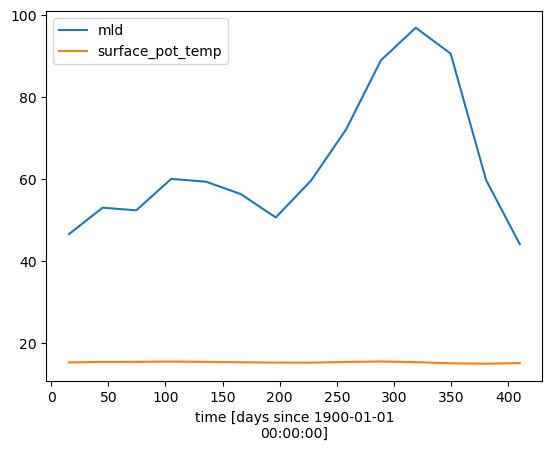

In [57]:
plot_vars(ds)

## 2. Reference parquet dataset

In [37]:
%%time

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "intermittent.parq", lazy=True
).get_mapper()

ds = xr.open_dataset(
    m,
    engine="zarr",
    backend_kwargs={"consolidated": False},
    decode_times=False,
    chunks="auto"
)

CPU times: user 30 ms, sys: 10.6 ms, total: 40.6 ms
Wall time: 370 ms


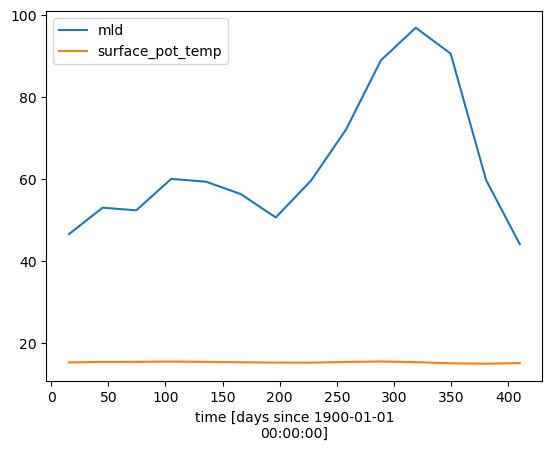

In [39]:
plot_vars(ds)